### Import Libraries

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, os
from pathlib import Path
from tqdm import tqdm

### User Variables/Paths

In [2]:
# user hyperparams
root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/' # path to save toy data files (mnist, svhn, fmnist, kmnist, etc)
img_size = 32
trans1 = torchvision.transforms.Compose([  
        torchvision.transforms.Resize((img_size,img_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1))
    ])  # for mnist and fmnist we replicate channels
trans2 = torchvision.transforms.Compose([
        torchvision.transforms.Resize((img_size,img_size)),
        torchvision.transforms.ToTensor()
    ])  # for cifar10 we don't replicate

### Basic Setup Code

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root_dir, transform=trans2, download=True)
fmnist_train = torchvision.datasets.FashionMNIST(root_dir, transform=trans1, download=True)
mnist_train = torchvision.datasets.MNIST(root_dir, transform=trans1, download=True)
kmnist_train = torchvision.datasets.KMNIST(root_dir, transform=trans1, download=True)
svhn_train = torchvision.datasets.SVHN(root_dir, split='train', transform=trans2, download=True)

cifar10_test = torchvision.datasets.CIFAR10(root_dir, train=False, transform=trans2, download=True)
fmnist_test = torchvision.datasets.FashionMNIST(root_dir, train=False, transform=trans1, download=True)
mnist_test = torchvision.datasets.MNIST(root_dir, train=False, transform=trans1, download=True)
kmnist_test = torchvision.datasets.KMNIST(root_dir, train=False, transform=trans1, download=True)
svhn_test = torchvision.datasets.SVHN(root_dir, split='test', transform=trans2, download=True)

Files already downloaded and verified
Using downloaded and verified file: /jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: /jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/test_32x32.mat


In [4]:
cifar10_train[0][0].shape,fmnist_train[0][0].shape,mnist_train[0][0].shape,kmnist_train[0][0].shape

(torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]))

In [5]:
cifar10_test[0][0].shape,fmnist_test[0][0].shape,mnist_test[0][0].shape,kmnist_test[0][0].shape

(torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]))

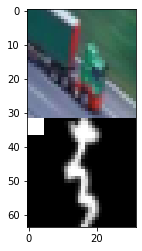

In [6]:
img = kmnist_train[50][0]
img[:,:5,:5] = 1.0
test_img = torch.hstack((cifar10_train[50][0],img))
plt.imshow(test_img.permute(1,2,0))

In [7]:
kmnist_train[50][0][:,:3,:3]=1.0
img = kmnist_train[50][0][:,:3,:3]
img[:,:3,:3]=100
img[:,:3,:3]

tensor([[[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]],

        [[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]],

        [[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]]])

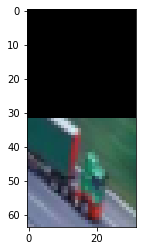

In [8]:
test_img = torch.hstack((torch.zeros((3,32,32)),cifar10_train[50][0]))
plt.imshow(test_img.permute(1,2,0))

# 2-Class Domino Datasets

## Create Datasets and Subfolder Heirarchies

In [9]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_svhn_bot_kmnist/' # path to save domino data
full_save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_svhn_bot_kmnist_2class_ro_1p0.csv' 
top_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}
bot_dataset = {'name':'kmnist', 'train_data':kmnist_train, 'test_data':kmnist_test}

In [10]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [top_dataset,bot_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for bot_label in tqdm(range(2)):
        for top_label in tqdm(range(2)):            
            bot_inds = (bot_dataset[f'{partition}_labels']==bot_label).nonzero().squeeze()  # indices for bottom images
            top_inds = (top_dataset[f'{partition}_labels']==top_label).nonzero().squeeze()  # indices for top images
            Path(os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/')).mkdir(parents=True, exist_ok=True)
            
            for file_idx,(bot_idx,top_idx) in tqdm(enumerate(zip(bot_inds[:num_imgs[partition]],top_inds[:num_imgs[partition]]))):
                if bot_dataset['name'] == 'kmnistPatch' and bot_label==1:
                    temp_img = bot_dataset[f'{partition}_data'][bot_idx][0]
                    temp_img[:,:5,:5]=1.0
                    img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],temp_img))
                else:
                    img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],bot_dataset[f'{partition}_data'][bot_idx][0]))
                final_path = os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/{file_idx}.jpg')
                plt.imsave(final_path,np.array(img.permute(1,2,0)))

/jet/home/nmurali/asc170022p/nmurali/anaconda3/envs/pl/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

8it [00:00, 74.27it/s]

16it [00:00, 49.91it/s]

22it [00:02,  6.17it/s]

31it [00:02, 10.67it/s]

42it [00:02, 17.52it/s]

56it [00:02, 28.40it/s]

70it [00:03, 38.76it/s]

98it [00:03, 70.00it/s]

119it [00:03, 91.10it/s]

147it [00:03, 122.36it/s]

166it [00:05, 30.18it/s] 

186it [00:06, 29.17it/s]

208it [00:06, 40.22it/s]

222it [00:06, 46.41it/s]

238it [00:06, 57.19it/s]

259it [00:07, 27.96it/s]

282it [00:10, 15.84it/s]

327it [00:10, 30.05it/s]

365it [00:10, 45.67it/s]

390it [00:10, 57.92it/s]

415it [00:12, 37.45it/s]

445it [00:12, 51.11it/s]

494it [00:12, 82.40it/s]

540it [00:12, 117.23it/s]

587it [00:13, 82.11it/s] 

636it [00:13, 114.53it/s]

688it [00:13, 155.82it/s]

727it [00:14, 103

802it [00:12, 161.36it/s]

833it [00:13, 121.61it/s]

857it [00:16, 29.71it/s] 

912it [00:16, 48.64it/s]

962it [00:16, 64.54it/s]

1029it [00:16, 101.20it/s]

1076it [00:16, 130.48it/s]

1117it [00:17, 158.86it/s]

1157it [00:17, 168.92it/s]

1196it [00:17, 198.08it/s]

1231it [00:17, 172.92it/s]

1260it [00:19, 59.76it/s] 

1298it [00:19, 79.67it/s]

1323it [00:19, 82.06it/s]

1375it [00:19, 114.03it/s]

1420it [00:19, 151.18it/s]

1449it [00:19, 163.12it/s]

1505it [00:20, 225.63it/s]

1559it [00:20, 279.13it/s]

1599it [00:20, 165.51it/s]

1633it [00:20, 186.77it/s]

1692it [00:20, 251.66it/s]

1731it [00:21, 211.72it/s]

1770it [00:21, 216.70it/s]

1821it [00:21, 268.57it/s]

1857it [00:21, 280.13it/s]

1908it [00:21, 330.02it/s]

1948it [00:21, 303.90it/s]

1984it [00:24, 52.11it/s] 

2009it [00:24, 48.04it/s]

2028it [00:25, 51.30it/s]

2069it [00:25, 74.23it/s]

2093it [00:25, 88.28it/s]

2142it [00:25, 131.73it/s]

2173it [00:25, 121.99it/s]

2218it [00:31, 19.46it/s] 

2236i

456it [00:01, 266.90it/s]

504it [00:01, 312.57it/s]

542it [00:04, 43.01it/s] 

569it [00:09, 18.98it/s]

610it [00:09, 26.67it/s]

640it [00:09, 34.55it/s]

685it [00:09, 50.96it/s]

714it [00:09, 57.90it/s]

738it [00:16, 13.11it/s]

800it [00:16, 47.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

58it [00:00, 562.56it/s]

115it [00:00, 325.51it/s]

153it [00:00, 331.43it/s]

190it [00:00, 342.29it/s]

227it [00:00, 338.02it/s]

263it [00:00, 336.60it/s]

307it [00:01, 250.11it/s]

336it [00:08, 15.92it/s] 

364it [00:08, 20.88it/s]

408it [00:08, 31.96it/s]

446it [00:08, 44.34it/s]

497it [00:08, 67.17it/s]

533it [00:08, 83.00it/s]

565it [00:09, 67.27it/s]

601it [00:09, 87.62it/s]

651it [00:09, 125.09it/s]

684it [00:09, 147.88it/s]

732it [00:11, 50.25it/s] 

756it [00:12, 44.19it/s]

800it [00:12, 62.00it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.91s/it]

0it [00:00, ?it/s]

47it [00:00, 465.30it/s]

94it [00:06, 12.72it/s] 

114it [00:06, 15.67it/s]

127

## Generate CSV file for corresponding dataset

In [11]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/top{lbl_idx}_bot{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)


## Create Top Blank Dataset Domino

In [12]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_blank_bot_svhn/'
full_save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_blank_bot_svhn_2class_ro_1p0.csv'
bot_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}

In [13]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [bot_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for bot_label in tqdm(range(2)):           
        bot_inds = (bot_dataset[f'{partition}_labels']==bot_label).nonzero().squeeze()  # indices for bottom images
        Path(os.path.join(save_dir,f'{partition}/{bot_label}/')).mkdir(parents=True, exist_ok=True)

        for file_idx,bot_idx in tqdm(enumerate(bot_inds[:num_imgs[partition]])):
            if bot_dataset['name'] == 'kmnistPatch' and bot_label==1:
                temp_img = bot_dataset[f'{partition}_data'][bot_idx][0]
                temp_img[:,:5,:5]=1.0
                img = torch.hstack((torch.zeros((3,32,32)),temp_img))
            else:
                img = torch.hstack((torch.zeros((3,32,32)),bot_dataset[f'{partition}_data'][bot_idx][0]))
            final_path = os.path.join(save_dir,f'{partition}/{bot_label}/{file_idx}.jpg')
            plt.imsave(final_path,np.array(img.permute(1,2,0)))

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.10it/s]
7it [00:03,  2.18it/s]
14it [00:03,  5.16it/s]
24it [00:03, 10.78it/s]
43it [00:03, 24.76it/s]
73it [00:03, 52.35it/s]
116it [00:03, 98.70it/s]
141it [00:03, 118.27it/s]
167it [00:03, 125.36it/s]
214it [00:04, 140.65it/s]
234it [00:04, 109.02it/s]
270it [00:04, 144.88it/s]
292it [00:07, 26.02it/s] 
337it [00:07, 42.31it/s]
362it [00:07, 51.81it/s]
404it [00:08, 76.70it/s]
439it [00:08, 100.71it/s]
469it [00:09, 47.25it/s] 
491it [00:10, 47.56it/s]
513it [00:11, 36.99it/s]
536it [00:11, 37.44it/s]
561it [00:18,  9.96it/s]
568it [00:18, 10.83it/s]
616it [00:19, 21.39it/s]
651it [00:19, 31.63it/s]
683it [00:19, 43.92it/s]
709it [00:22, 20.29it/s]
748it [00:22, 30.89it/s]
813it [00:22, 55.10it/s]
864it [00:22, 79.22it/s]
925it [00:22, 116.61it/s]
972it [00:22, 142.13it/s]
1014it [00:23, 170.44it/s]
1055it [00:23, 195.12it/s]
1093it [00:24, 99.42it/s] 
1121it [00:27, 27.37it/s]
1165it [00:27, 39.58it/s]
1201it [

617it [00:06, 70.04it/s]
663it [00:07, 40.26it/s]
686it [00:08, 46.68it/s]
700it [00:08, 39.60it/s]
735it [00:09, 48.62it/s]
800it [00:09, 84.74it/s]
100%|██████████| 2/2 [00:32<00:00, 16.38s/it]


## Generate CSV File for corresponding Blank Domino Dataset

In [14]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)


## Create Bottom Blank Dataset Domino

In [15]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_svhn_bot_blank/'
full_save_path = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_svhn_bot_blank_2class_ro_1p0.csv'
top_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}

In [16]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [top_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for top_label in tqdm(range(2)):           
        top_inds = (top_dataset[f'{partition}_labels']==top_label).nonzero().squeeze()  # indices for bottom images
        Path(os.path.join(save_dir,f'{partition}/{top_label}/')).mkdir(parents=True, exist_ok=True)

        for file_idx,top_idx in tqdm(enumerate(top_inds[:num_imgs[partition]])):
            if top_dataset['name'] == 'kmnistPatch' and top_label==1:
                temp_img = top_dataset[f'{partition}_data'][top_idx][0]
                temp_img[:,:5,:5]=1.0
                img = torch.hstack((temp_img,torch.zeros((3,32,32))))
            else:
                img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],torch.zeros((3,32,32))))
            final_path = os.path.join(save_dir,f'{partition}/{top_label}/{file_idx}.jpg')
            plt.imsave(final_path,np.array(img.permute(1,2,0)))

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
12it [00:00, 37.92it/s]
35it [00:04,  7.55it/s]
70it [00:04, 18.91it/s]
87it [00:04, 25.42it/s]
107it [00:06, 16.17it/s]
130it [00:06, 22.25it/s]
155it [00:07, 27.22it/s]
188it [00:07, 43.07it/s]
204it [00:07, 44.34it/s]
226it [00:08, 48.30it/s]
244it [00:08, 59.59it/s]
278it [00:08, 90.15it/s]
298it [00:08, 92.44it/s]
322it [00:15, 10.36it/s]
346it [00:15, 14.59it/s]
384it [00:15, 23.93it/s]
419it [00:15, 35.41it/s]
451it [00:16, 46.13it/s]
473it [00:16, 51.56it/s]
491it [00:19, 20.93it/s]
514it [00:19, 24.54it/s]
562it [00:19, 40.95it/s]
609it [00:20, 53.39it/s]
646it [00:20, 72.02it/s]
666it [00:26, 14.45it/s]
680it [00:26, 16.32it/s]
691it [00:27, 16.59it/s]
727it [00:27, 27.50it/s]
756it [00:27, 38.88it/s]
799it [00:28, 46.65it/s]
847it [00:28, 66.33it/s]
875it [00:28, 81.72it/s]
929it [00:28, 124.36it/s]
962it [00:28, 147.09it/s]
993it [00:36, 14.77it/s] 
1015it [00:36, 17.47it/s]
1040it [00:36, 22.77it/s]
1083it [00:37, 35

769it [00:31, 25.40it/s]
800it [00:31, 25.05it/s]
100%|██████████| 2/2 [00:51<00:00, 25.66s/it]


## Generate CSV File for corresponding Blank Domino Dataset

In [17]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)
